# Baseline Model Experiment with different bands product 

## Data Transformation for Bands  

In [1]:
import os 
import sys 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
# Pytorch module 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import random
from typing import Any, Mapping
from time import gmtime, strftime

# set working directory
os.chdir('/home/jovyan/contrails/contrails_detection/')

# Project Module
import config
import src.utils as utils
from src.dataset import ContrailsDataset
from src.model import BaseUnet, SegmentLightning
from src.train import Trainer
from src.trainer_lgt import TrainerLightning

In [2]:
def clear_torch_cache():
    torch.cuda.empty_cache()
    print("Cleared PyTorch GPU cache.")

# Run the function to clear GPU cache
clear_torch_cache()

Cleared PyTorch GPU cache.


In [3]:
!nvidia-smi

Fri Jul 26 19:04:42 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.03   Driver Version: 525.116.03   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:03:00.0 Off |                  Off |
| 41%   43C    P8    12W / 140W |      2MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
## Load file from csv split into train/test
from sklearn.model_selection import train_test_split
df = pd.read_csv(config.CSV_TRAIN_REC, index_col=0)
train_df, valid_df = train_test_split(df[df.Class.isin([0,1])], test_size = .2, random_state=42)
train_df.head()

,Image_ID,Class
16081,8975896718947475053,0
17494,2887461863286016746,0
15040,1323985642378913441,1
7528,8578962451401293377,0
18488,1733973341297589475,1


In [6]:
train_df.shape

(16423, 2)

In [6]:
img_n = train_df.iloc[0, 0]
config.DATA_DIR + 'train' + '/' + str(img_n)

'/home/jovyan/contrails/data/train/8975896718947475053'

### Bands Products
 - ALL channels
 - Ash RGB
 - Water Vapour bands- band #8,9,10
 - Important Bands by Random Forest(ch-8, 13, 16)

In [7]:
def compute_TDi_ashrgb(img, T_threshold):
    """
    Compute the Temperature Difference (TD) and Temperature Difference Index (TDi) from an image tensor.

    Parameters:
    - img: Image tensor containing multiple bands (C x H x W)
    - T_threshold: Threshold temperature for TDi calculation, float

    Returns:
    - img_with_TD_TDi: Image tensor with additional TD and TDi channels (C+2 x H x W)
    """
    ash_rgb = utils.get_rgb(img/255.0)
    gauss_fimg = utils.gaussian_filter_normalization(img)
    # Extract relevant bands
    band10 = gauss_fimg[2, :, :] # Band 10 (7.3 µm)
    band13 = gauss_fimg[5, :, :] # Band 13 (10.3 µm)
    band8 = gauss_fimg[0, :, :] # Band 8 (6.2 µm)
    band11 = gauss_fimg[3, :, :] # Band 11 (8.4 µm)

    # Compute Temperature Difference (TD)
    TD = band13 - band10

    # Compute Temperature Difference Index (TDi)
    TDi = TD / (1 + torch.exp(band13 - T_threshold))
    
    # Compute TD& TDi for bands-8,11
    TD_11 = band11 - band8
    TDi_11 = TD_11/(1 + torch.exp(band11 - T_threshold))

    # Add TD and TDi as new channels
    img_with_TD_TDi = torch.cat([ash_rgb, TD.unsqueeze(0), TDi.unsqueeze(0), 
                                 TD_11.unsqueeze(0), TDi_11.unsqueeze(0)], dim=0)

    return img_with_TD_TDi


In [8]:
%%time
torch.cuda.empty_cache()
torch.manual_seed(22)
transform = transforms.Compose([
    # Add your desired transformations here
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: utils.gaussian_filter_normalization(x)),
    transforms.Lambda(lambda x: compute_TDi_ashrgb(x, -5))
])


train_dataset = ContrailsDataset(dataframe=train_df,
                                 root_dir=config.DATA_DIR+'train', 
                                 transform=transform, 
                                 sequence_index=config.TS # nth:5 sequence image
                                ) 

valid_dataset = ContrailsDataset(dataframe=valid_df, 
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform, 
                                 sequence_index=config.TS
                                )
## Data Loaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=8, 
                              shuffle=True, 
                              num_workers=config.WORKERS, 
                              pin_memory=True, 
                              prefetch_factor=config.WORKERS,
                             )

valid_dataloader = DataLoader(valid_dataset, 
                              batch_size=8, 
                              shuffle=False, 
                              num_workers=config.WORKERS, 
                              prefetch_factor=config.WORKERS
                             )

CPU times: user 4.31 ms, sys: 179 µs, total: 4.49 ms
Wall time: 3.65 ms


In [9]:
%%time
image, mask = next(iter(train_dataloader))
image.shape, mask.shape

CPU times: user 2.42 s, sys: 1.64 s, total: 4.06 s
Wall time: 12.2 s


(torch.Size([8, 7, 256, 256]), torch.Size([8, 1, 256, 256]))

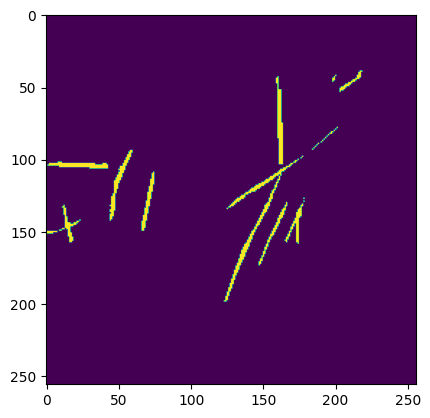

In [13]:
plt.imshow(mask[0, 0, :, :])

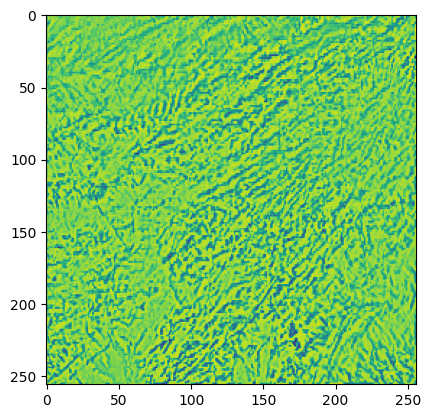

In [14]:
plt.imshow(image[0, 6, :, :])

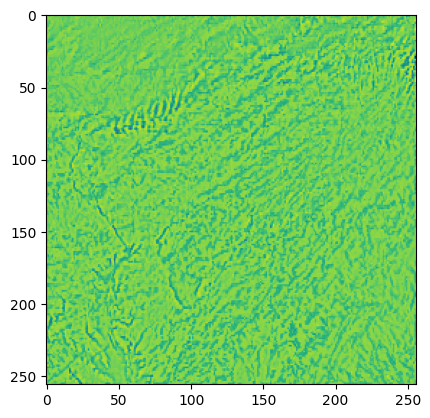

In [15]:
plt.imshow(image[0, 4, :, :])

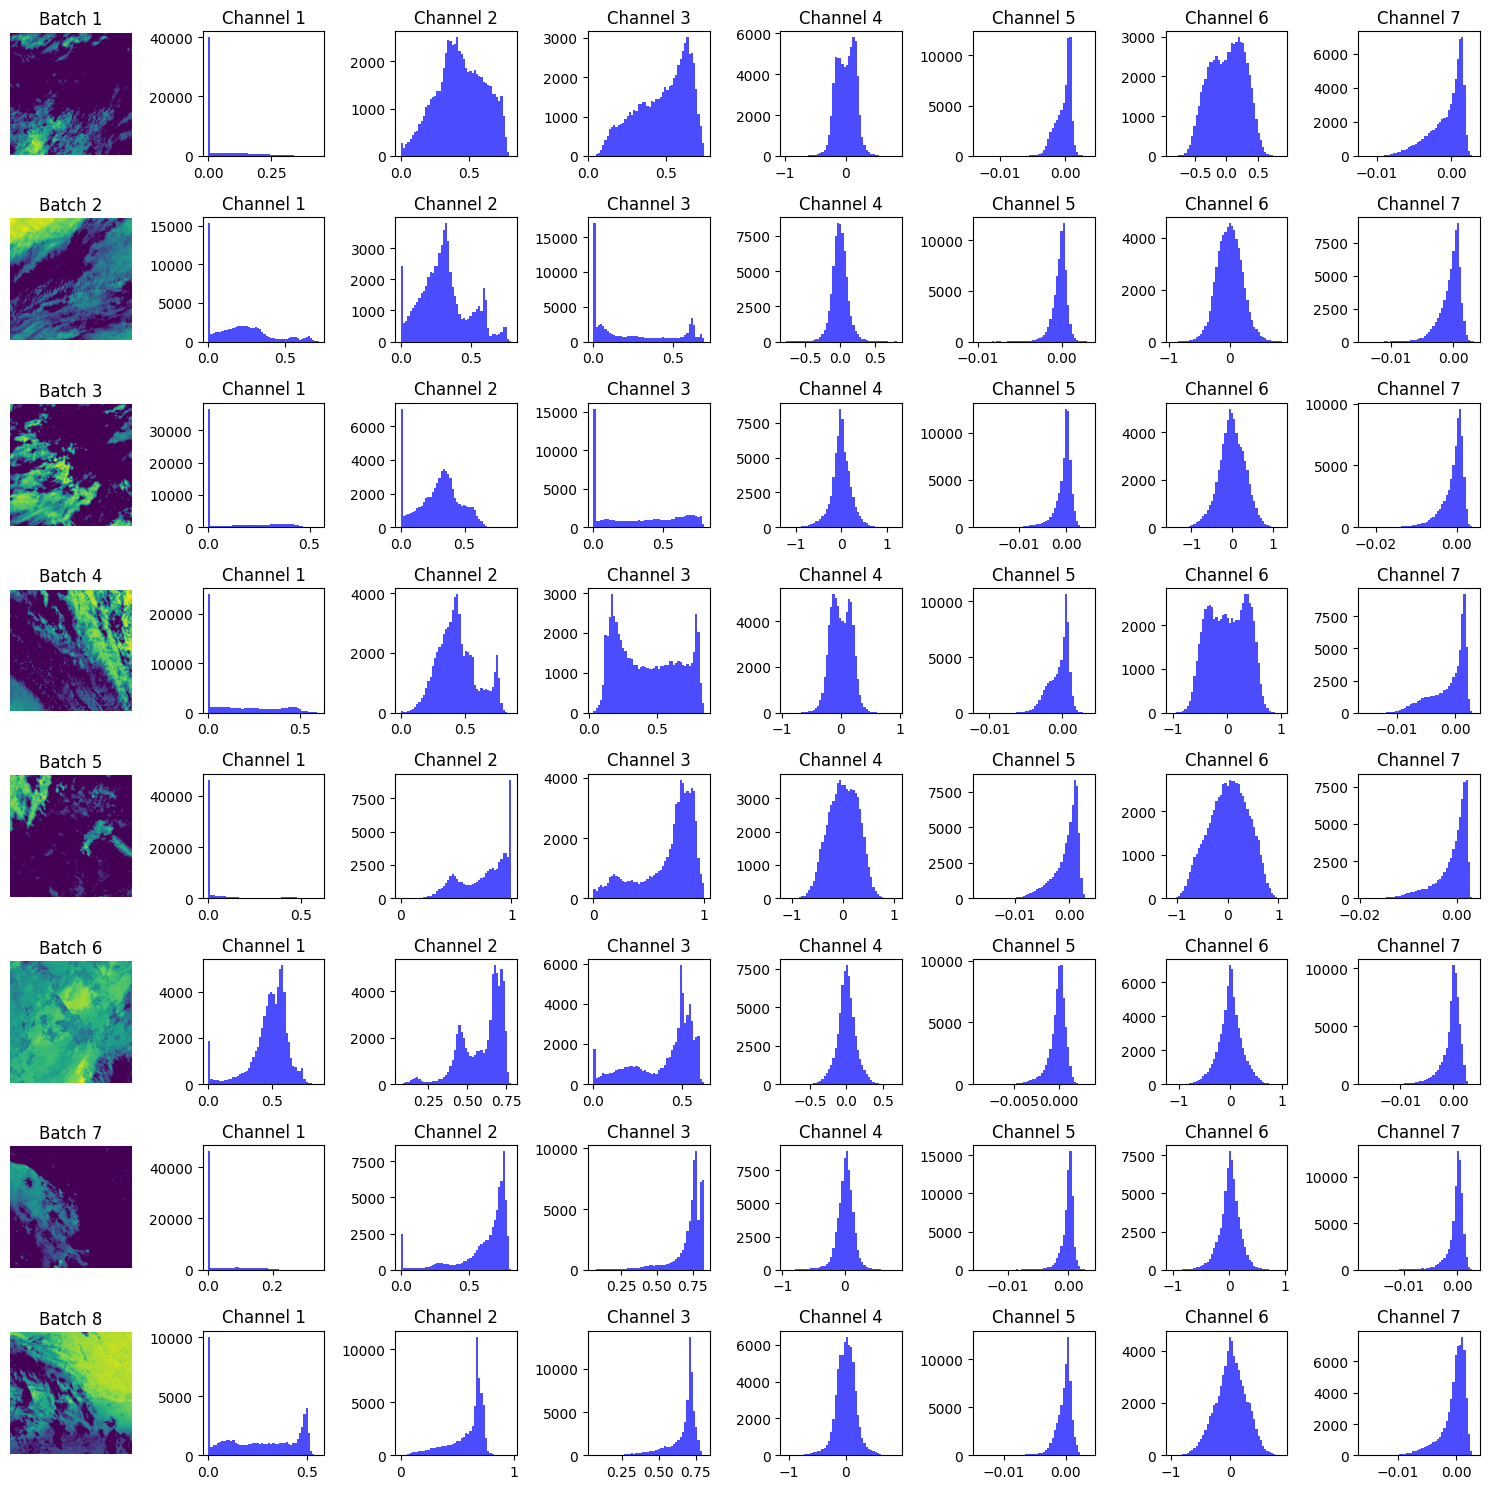

In [16]:
utils.plot_batch_histogram(image)

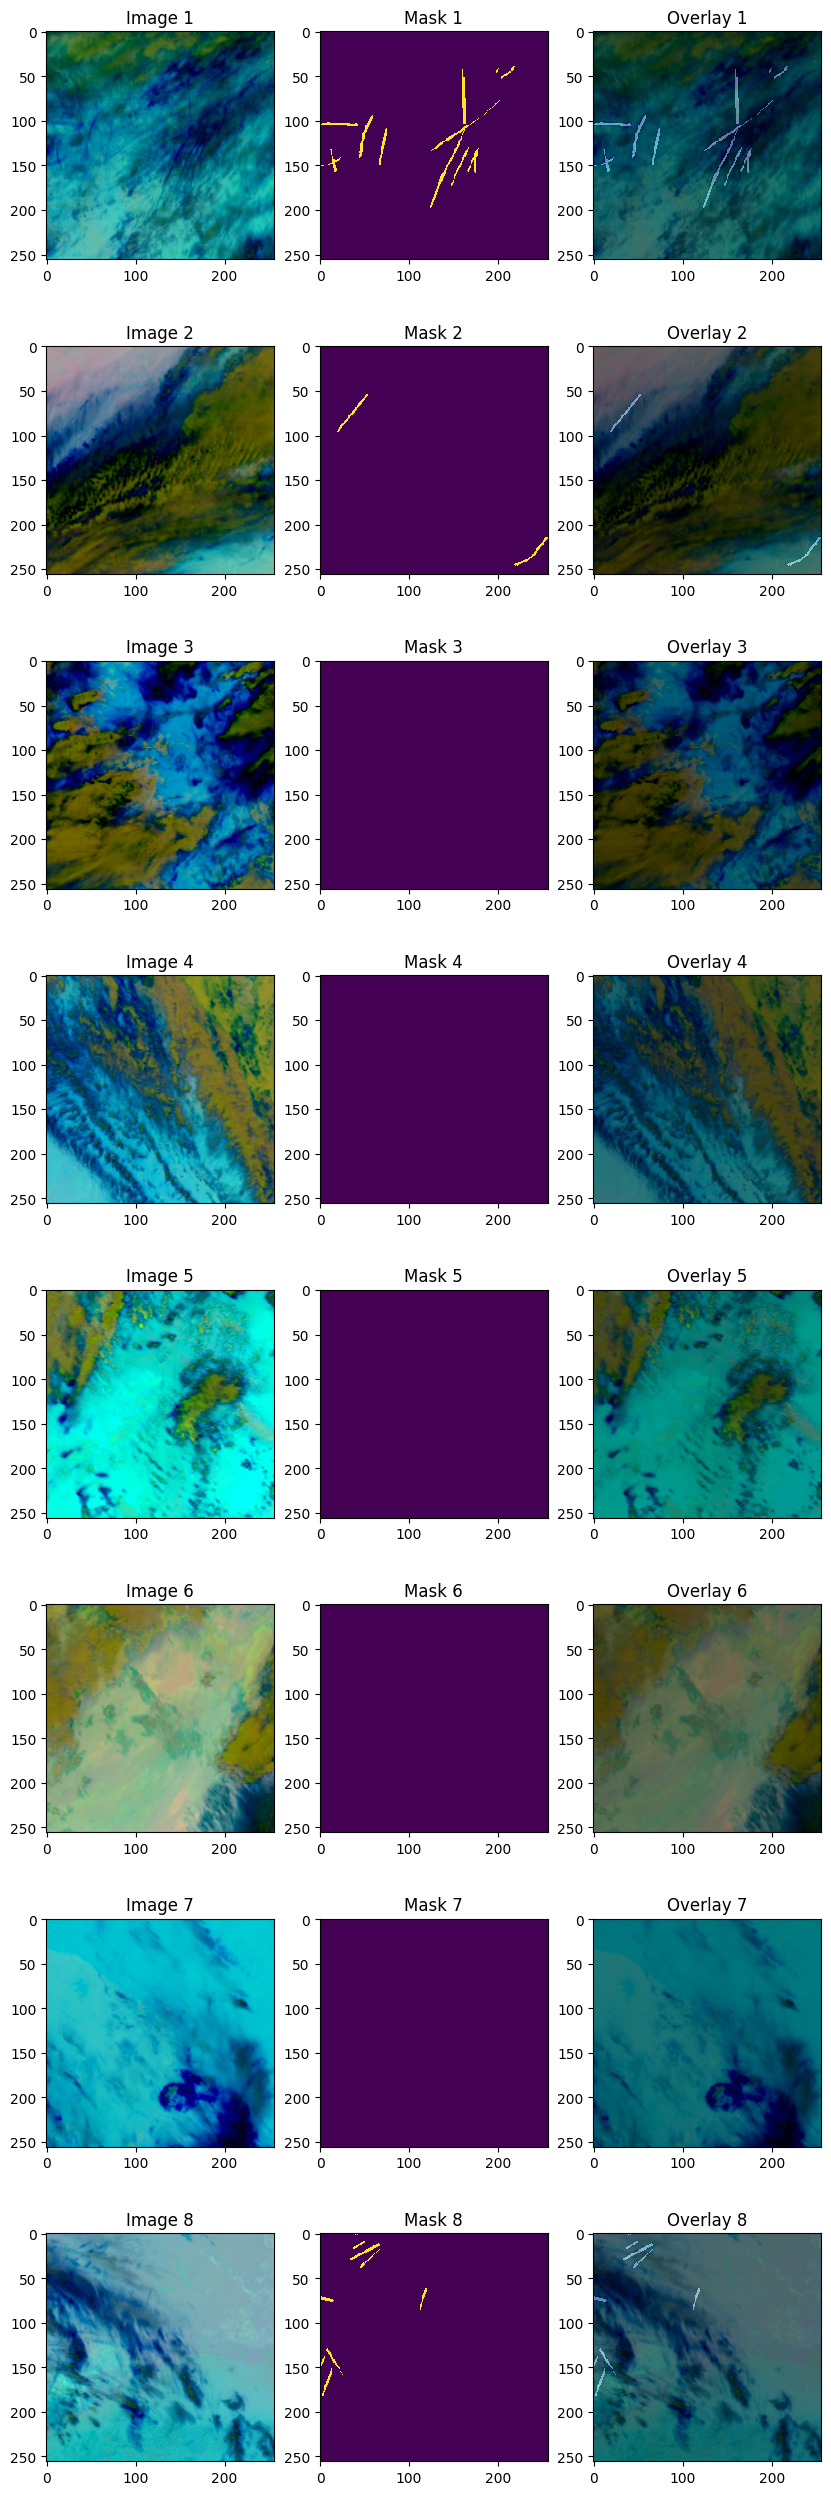

In [15]:
utils.plot_image_and_mask(image, mask)

In [18]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


model_tr = BaseUnet(in_channels=7, out_channels=1, features=[32, 64, 128, 256])

In [19]:
config.DEV

'OBJ-2'

In [23]:
# Paths
_expr_name = config.NAME + "AshRGB_TDi_B7"

# Tensorboard
tb_path = config.TB_PATH +"/"+ config.DEV
logger = TensorBoardLogger(tb_path, name=_expr_name)


main_model = model_tr.to(config.DEVICE)

#weights = torch.tensor([120])
criterion = torch.nn.BCEWithLogitsLoss()

# Gradient clipping to avoid exploding gradients
torch.nn.utils.clip_grad_norm_(main_model.parameters(), max_norm=1.0)
# Schedular
scheduler_name = 'ReduceLROnPlateau'
scheduler_params = {'factor': 0.1, 'patience': 3, 'min_lr': 1e-6}
# Training Model
model_tr_lgt = TrainerLightning(main_model,
                                     criterion,
                                     config.LR_RATE,
                                     train_dataset,
                                     valid_dataset,
                                     scheduler_name,
                                     scheduler_params,
                                     config.BATCH_SIZE, 
                                     config.WORKERS
                                    )

early_stop_callback = EarlyStopping(monitor='val_loss', patience=20)

checkpoint_callback = ModelCheckpoint(
        dirpath=config.MODEL_DIR + "/" +_expr_name,
        monitor="val_loss",
        save_last=True,
        save_top_k=5
    )

print(_expr_name, image.shape[1])

baseline-unetAshRGB_TDi_B7 7


In [24]:
trainer_lgt = pl.Trainer(
        logger=logger,
        precision=config.PRECISION,
        accelerator=config.ACCELERATOR,
        devices=[0],
        min_epochs=1,
        max_epochs=config.NUM_EPOCHS,
        callbacks=[checkpoint_callback, early_stop_callback]
    )

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
%time
#run trainer
torch.cuda.empty_cache()
trainer_lgt.fit(model_tr_lgt)

Missing logger folder: tb_logs/OBJ-2/baseline-unetAshRGB_TDi_B7


CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 24.1 µs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | BaseUnet          | 7.8 M 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
15.534    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Result Analysis

In [ ]:
image_p, mask_p = next(iter(valid_dataloader))

In [ ]:
image_p.shape #/home/jovyan/contrails/contrails_detection/models/checkpoints/poc1/baseline-unetTop_Feature_AshRGB

In [ ]:
utils.plot_batch_histogram(image_p)

### Baseline U-Net ALL channel result analysis 

In [ ]:
_expr_name = config.NAME+"AshRGB"
norm_checkpoint_path = config.MODEL_DIR+"/"+_expr_name + "/last-v1.ckpt"
checkpoint = torch.load(norm_checkpoint_path)
# Extract the state_dict from the checkpoint
saved_state_dict = checkpoint['state_dict']
prefix = "model."  # Adjust the prefix as needed
filtered_state_dict = {k[len(prefix):]: v for k, v in saved_state_dict.items() if k.startswith(prefix)}

model_v = BaseUnet(in_channels=3, out_channels=1)
model_v.load_state_dict(filtered_state_dict)
model_v.eval()

model = model_v.to(config.DEVICE)
data = image_p.to(config.DEVICE)
prediction = torch.sigmoid(model_v(data))

#utils.plot_rgb_and_mask(image_p, mask_p, prediction.detach())

In [ ]:
prediction.shape

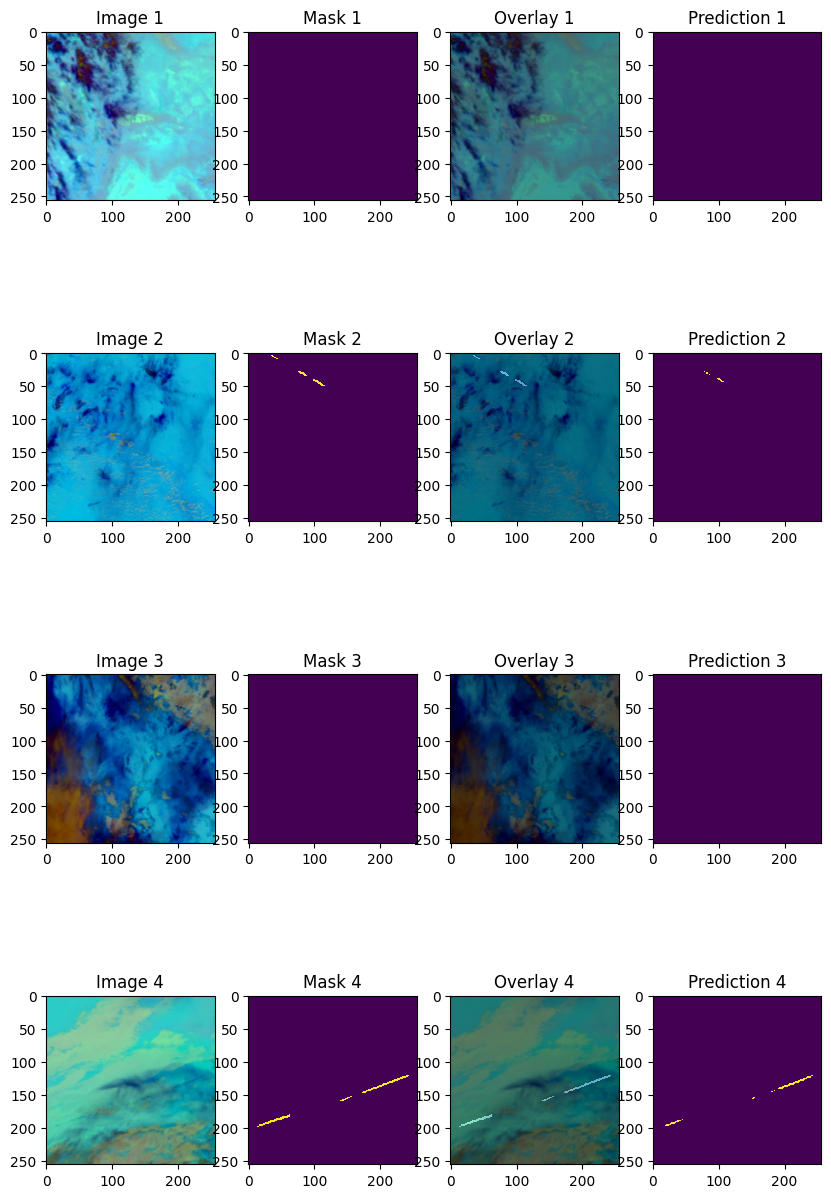

In [78]:
utils.plot_image_and_mask(image_p, mask_p, prediction.detach() > 0.4)

### Baseline Ash RGB model result

In [41]:
config.MODEL_DIR+"/"+_expr_name

'/home/jovyan/contrails/contrails_detection/models/checkpoints/Obj1/baseline-unetALL'

In [43]:
config.NAME+"AshRGB"


'baseline-unetAshRGB'

In [ ]:
_expr_name = config.NAME+"AshRGB"
norm_checkpoint_path = config.MODEL_DIR+"/"+_expr_name + "/epoch=17-step=73908.ckpt"
checkpoint = torch.load(norm_checkpoint_path)
# Extract the state_dict from the checkpoint
saved_state_dict = checkpoint['state_dict']
prefix = "model."  # Adjust the prefix as needed
filtered_state_dict = {k[len(prefix):]: v for k, v in saved_state_dict.items() if k.startswith(prefix)}

model_v = BaseUnet(in_channels=3, out_channels=1)
model_v.load_state_dict(filtered_state_dict)
model_v.eval()

model = model_v.to(config.DEVICE)
data = image_p.to(config.DEVICE)
prediction = torch.sigmoid(model_v(data))

In [ ]:
utils.plot_image_and_mask(image_p, mask_p, prediction.detach())

In [ ]:
data_tr = image.to(config.DEVICE)
pred_tr = torch.sigmoid(model_v(data_tr))
utils.plot_image_and_mask(image, mask, pred_tr.detach())